# Differential Vision Tranformer

## Imports

In [ ]:
import cv2
import time
import math
import torch
import seaborn
import torchvision
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.autoaugment import AutoAugmentPolicy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Dataset Class

In [ ]:
class CIFAR10PDataset(Dataset):
    def __init__(self, train=True, patch_size=4, transform=None):
        self.data = datasets.CIFAR10(root="./data", train=train, download=True)
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform is not None:
            img = self.transform(img)

        # Creating the image into patches
        C, _, _ = img.shape
        patches = img.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.permute(1, 2, 0, 3, 4).contiguous()
        patches = patches.view(-1, C * self.patch_size * self.patch_size) # Flatten each patch into the vector of size patch_size x patch_size x n_channels
        
        return patches, label

## Differential ViT Class

In [ ]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
        
    def forward(self, x):
        norm = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        return self.weight * (x / norm)

class TransformerEncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=8/3, dropout=0.0, layer_idx=0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads // 2  # Divided by 2 for Q1/Q2, K1/K2 split
        
        self.norm1 = RMSNorm(dim)
        self.norm2 = RMSNorm(dim)
        
        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.o = nn.Linear(dim, dim, bias=False)
        
        # Lambda parameters for differential attention
        lambda_init = 0.8 - 0.6 * math.exp(-0.3 * layer_idx)
        self.lambda_init = lambda_init
        self.register_parameter('lambda_q1', nn.Parameter(torch.zeros(self.head_dim)))
        self.register_parameter('lambda_k1', nn.Parameter(torch.zeros(self.head_dim)))
        self.register_parameter('lambda_q2', nn.Parameter(torch.zeros(self.head_dim)))
        self.register_parameter('lambda_k2', nn.Parameter(torch.zeros(self.head_dim)))
        
        # Head normalization layers
        self.head_norms = nn.ModuleList([nn.LayerNorm(self.head_dim * 2) for _ in range(num_heads)])
        
        # MLP
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim, bias=False),
            nn.GELU(),  # Can be replaced with SwiGLU if needed
            nn.Linear(mlp_hidden_dim, dim, bias=False),
            nn.Dropout(dropout)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        
        x_norm = self.norm1(x)
        lambda_val = torch.exp(self.lambda_q1 @ self.lambda_k1) - torch.exp(self.lambda_q2 @ self.lambda_k2) + self.lambda_init
        
        # QKV projections
        qkv = self.qkv(x_norm).reshape(B, N, 3, self.num_heads, self.head_dim * 2)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Split queries and keys for differential attention
        q1, q2 = torch.split(q, self.head_dim, dim=-1) 
        k1, k2 = torch.split(k, self.head_dim, dim=-1) 
        
        scale = 1.0 / math.sqrt(self.head_dim)
    
        attn1 = torch.matmul(q1, k1.transpose(-2, -1)) * scale 
        attn2 = torch.matmul(q2, k2.transpose(-2, -1)) * scale 
        
        # Apply softmax and differential attention
        attn1 = F.softmax(attn1, dim=-1)
        attn2 = F.softmax(attn2, dim=-1)
        diff_attn = attn1 - lambda_val * attn2 
        
        # Apply attention to values and normalize per head
        head_outputs = []
        for i in range(self.num_heads):
            # Get output for each head
            head_output = torch.matmul(diff_attn[:, i], v[:, i]) 
            
            # Apply normalization and scaling as specified in paper
            head_output = self.head_norms[i](head_output) * (1 - self.lambda_init)
            head_outputs.append(head_output)
        
        x_attn = torch.cat(head_outputs, dim=-1)  # [B, N, dim]
        x_attn = self.o(x_attn)
        x_attn = self.dropout(x_attn)
        
        # First residual connection
        x = x + x_attn
        
        # Second normalization
        x_norm2 = self.norm2(x)
        
        # MLP block
        x_mlp = self.mlp(x_norm2)
        
        # Second residual connection
        x = x + x_mlp
        
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, depth, emb_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(emb_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.attn_weights = []

    def forward(self, x):
        self.attn_weights = []
        for layer in self.layers:
            x = layer(x)
            self.attn_weights.append(layer.attn_weights)
        return x

class ViT(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = "1d"):
        super().__init__()
        self.positional_embeddings = positional_embeddings
        self.emb_dim = emb_dim

        # Linear Embedding of patches
        self.patch_embed = nn.Linear(in_features=patch_size * patch_size * in_channels, out_features=emb_dim, bias=True)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim).to(device))
        
        num_patches = (img_size // patch_size) ** 2
        num_patches_per_side = img_size // patch_size
        
        if positional_embeddings is None:
            pass
        elif positional_embeddings == "1d":
            self.pos_embed = nn.Parameter(torch.randn(1, 1 + num_patches, emb_dim).to(device))
        elif positional_embeddings == "2d":
             self.pos_embed_2d = nn.Parameter(
                torch.randn(1, num_patches_per_side, num_patches_per_side, emb_dim).to(device)
            )
        elif positional_embeddings == "sinusoidal":
            self.register_buffer(
                'pos_embed_sinusoidal',
                self.get_2d_sinusoidal_pos_embed(emb_dim, num_patches_per_side).unsqueeze(0)
            ) 
        self.dropout = nn.Dropout(dropout)
        self.transformer = TransformerEncoder(depth, emb_dim, num_heads, mlp_ratio, dropout)
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        B, N, _ = x.shape
        # ============================ Embed Patches =====================================
        x = self.patch_embed(x)  # -> (B, N, emb_dim)
        
        # ============================= Prepend CLS =====================================
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, emb_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 1 + N, emb_dim)
        
        # ============================ Add Pos Embed =====================================
        if self.positional_embeddings is None:
            pass
        elif self.positional_embeddings == "1d":
            x += self.pos_embed
        elif self.positional_embeddings == "2d":
            pos_embed = self.pos_embed_2d.view(1, -1, self.emb_dim)
            pos_embed = torch.cat([torch.zeros(1, 1, self.emb_dim).to(device), pos_embed], dim=1)
            x += pos_embed
        elif self.positional_embeddings == "sinusoidal":
            pos_embed = torch.cat([torch.zeros(1, 1, self.emb_dim).to(device), self.pos_embed_sinusoidal], dim=1)
            x += pos_embed
            
        x = self.dropout(x)
       
        # ========================== Transformer Encoder =================================
        x = self.transformer(x)
        
        # ========================== Classification Head =================================
        cls_out = x[:, 0]
        out = self.head(cls_out)
        
        # ================================================================================
        return out

    def get_2d_sinusoidal_pos_embed(self, embed_dim, grid_size):
        def get_1d_sin_cos_pos_embed(embed_dim, pos):
            dim_half = embed_dim // 2
            omega = torch.arange(dim_half, dtype=torch.float32) / dim_half
            omega = 1.0 / (10000 ** omega)
            out = torch.einsum('p,d->pd', pos, omega)
            emb = torch.cat([torch.sin(out), torch.cos(out)], dim=-1)
            return emb
    
        grid_h = torch.arange(grid_size, dtype=torch.float32)
        grid_w = torch.arange(grid_size, dtype=torch.float32)
        grid = torch.meshgrid(grid_h, grid_w, indexing='ij')
        grid = torch.stack(grid, dim=-1).reshape(-1, 2)  # [N, 2]
    
        pos_emb_h = get_1d_sin_cos_pos_embed(embed_dim // 2, grid[:, 0])
        pos_emb_w = get_1d_sin_cos_pos_embed(embed_dim // 2, grid[:, 1])
        return torch.cat([pos_emb_h, pos_emb_w], dim=1)  # [N, D]

### Hyperparameters

In [ ]:
# Fixed vars
img_size    = 32
in_channels = 3
num_classes = 10
batch_size  = 32

# Tuneable hyperparameters
emb_dim    = 128
patch_size = 4
depth      = 4
num_heads  = 4
lr         = 0.001
mlp_ratio  = 2.0
dropout    = 0.2
epochs     = 50

### Functions for training, evaluating and plotting

In [ ]:
def train_model(model, lr, epochs, loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses, train_accuracies = [], []

    start_time = time.time()
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
    
        for x, y in loader:
            x, y = x.to(device), y.to(device)
    
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
        train_loss = epoch_loss / total
        train_acc = (correct / total) * 100
    
        print(f"Train Loss: {round(train_loss, 4)} | Train Acc: {round(train_acc, 2)}%")
    
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
    end_time = time.time()
    print(f"Time taken to train: {round(end_time - start_time, 4)} seconds")

    return train_losses, train_accuracies

def plot_loss_and_acc(losses_arr, accuracies_arr):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].plot(losses_arr, label='Train Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss Curve')
    axes[0].grid()
    axes[0].legend()
    
    axes[1].plot(accuracies_arr, label='Train Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training Accuracy Curve')
    axes[1].grid()
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

def evaluate(model, loader):
    criterion = nn.CrossEntropyLoss()
    
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item() * x.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / total, correct / total

## Dataloaders and transforms

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_initial = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform)
test_dataset_initial = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform)

train_loader_initial = DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True)
test_loader_initial = DataLoader(test_dataset_initial, batch_size=batch_size, shuffle=False)

### Define model

In [ ]:
model_initial = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)

### Train model

In [32]:
train_losses_initial, train_accuracies_initial = train_model(model_initial, lr, epochs, train_loader_initial, device)

Epoch 1/50
Train Loss: 1.7022 | Train Acc: 37.51%

Epoch 2/50
Train Loss: 1.4137 | Train Acc: 48.96%

Epoch 3/50
Train Loss: 1.3058 | Train Acc: 52.88%

Epoch 4/50
Train Loss: 1.2309 | Train Acc: 55.76%

Epoch 5/50
Train Loss: 1.1709 | Train Acc: 58.05%

Epoch 6/50
Train Loss: 1.1219 | Train Acc: 59.80%

Epoch 7/50
Train Loss: 1.0736 | Train Acc: 61.51%

Epoch 8/50
Train Loss: 1.0347 | Train Acc: 62.93%

Epoch 9/50
Train Loss: 0.9978 | Train Acc: 64.32%

Epoch 10/50
Train Loss: 0.9578 | Train Acc: 65.63%

Epoch 11/50
Train Loss: 0.9325 | Train Acc: 66.56%

Epoch 12/50
Train Loss: 0.8965 | Train Acc: 67.91%

Epoch 13/50
Train Loss: 0.8640 | Train Acc: 69.05%

Epoch 14/50
Train Loss: 0.8373 | Train Acc: 70.06%

Epoch 15/50
Train Loss: 0.8087 | Train Acc: 70.94%

Epoch 16/50
Train Loss: 0.7856 | Train Acc: 71.79%

Epoch 17/50
Train Loss: 0.7639 | Train Acc: 72.43%

Epoch 18/50
Train Loss: 0.7346 | Train Acc: 73.49%

Epoch 19/50
Train Loss: 0.7135 | Train Acc: 74.30%

Epoch 20/50
Train Los

### Plotting loss and accuracy graphs

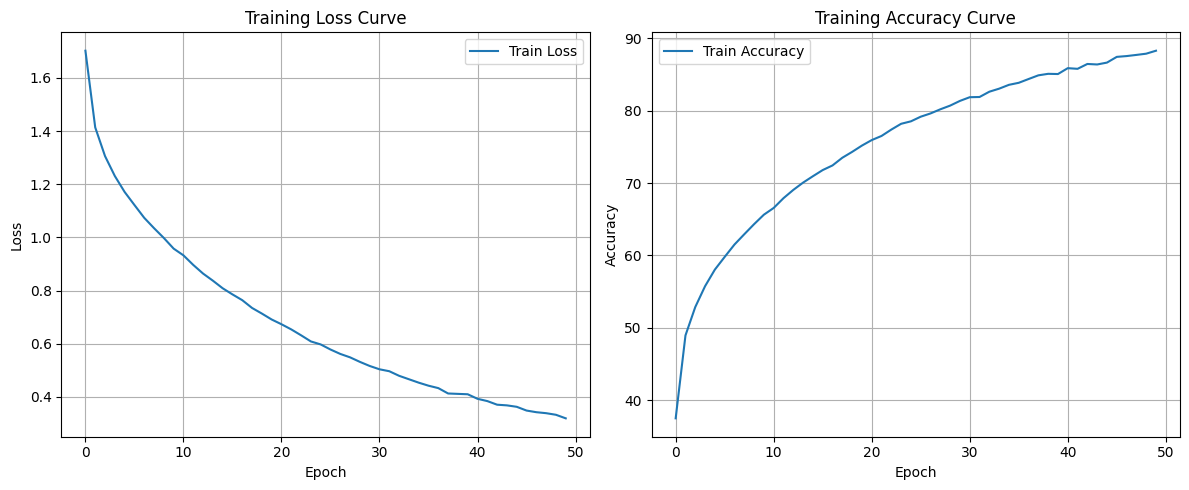

In [33]:
plot_loss_and_acc(train_losses_initial, train_accuracies_initial)

### Evaluating the model

In [34]:
test_loss_initial, test_acc_initial = evaluate(model_initial, test_loader_initial)
print(f"\nFinal Test Loss: {round(test_loss_initial, 4)} | Final Test Accuracy: {round(test_acc_initial * 100, 2)}%")


Final Test Loss: 1.3706 | Final Test Accuracy: 65.72%


## Path Size Variation

### Patch Size 2

In [12]:
patch_size = 2

train_dataset_ps2 = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform)
test_dataset_ps2 = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform)

train_loader_ps2 = DataLoader(train_dataset_ps2, batch_size=batch_size, shuffle=True)
test_loader_ps2 = DataLoader(test_dataset_ps2, batch_size=batch_size, shuffle=False)

model_ps2 = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_ps2, train_accuracies_ps2 = train_model(model_ps2, lr, epochs, train_loader_ps2, device)

Epoch 1/50
Train Loss: 1.6724 | Train Acc: 38.71%

Epoch 2/50
Train Loss: 1.4015 | Train Acc: 49.20%

Epoch 3/50
Train Loss: 1.2895 | Train Acc: 53.46%

Epoch 4/50
Train Loss: 1.2134 | Train Acc: 56.14%

Epoch 5/50
Train Loss: 1.1529 | Train Acc: 58.43%

Epoch 6/50
Train Loss: 1.0973 | Train Acc: 60.33%

Epoch 7/50
Train Loss: 1.0508 | Train Acc: 62.03%

Epoch 8/50
Train Loss: 1.0085 | Train Acc: 63.95%

Epoch 9/50
Train Loss: 0.9705 | Train Acc: 65.50%

Epoch 10/50
Train Loss: 0.9328 | Train Acc: 66.69%

Epoch 11/50
Train Loss: 0.9003 | Train Acc: 67.71%

Epoch 12/50
Train Loss: 0.8732 | Train Acc: 68.51%

Epoch 13/50
Train Loss: 0.8425 | Train Acc: 69.85%

Epoch 14/50
Train Loss: 0.8134 | Train Acc: 70.95%

Epoch 15/50
Train Loss: 0.7841 | Train Acc: 71.69%

Epoch 16/50
Train Loss: 0.7628 | Train Acc: 72.67%

Epoch 17/50
Train Loss: 0.7427 | Train Acc: 73.50%

Epoch 18/50
Train Loss: 0.7173 | Train Acc: 74.14%

Epoch 19/50
Train Loss: 0.6991 | Train Acc: 74.88%

Epoch 20/50
Train Los

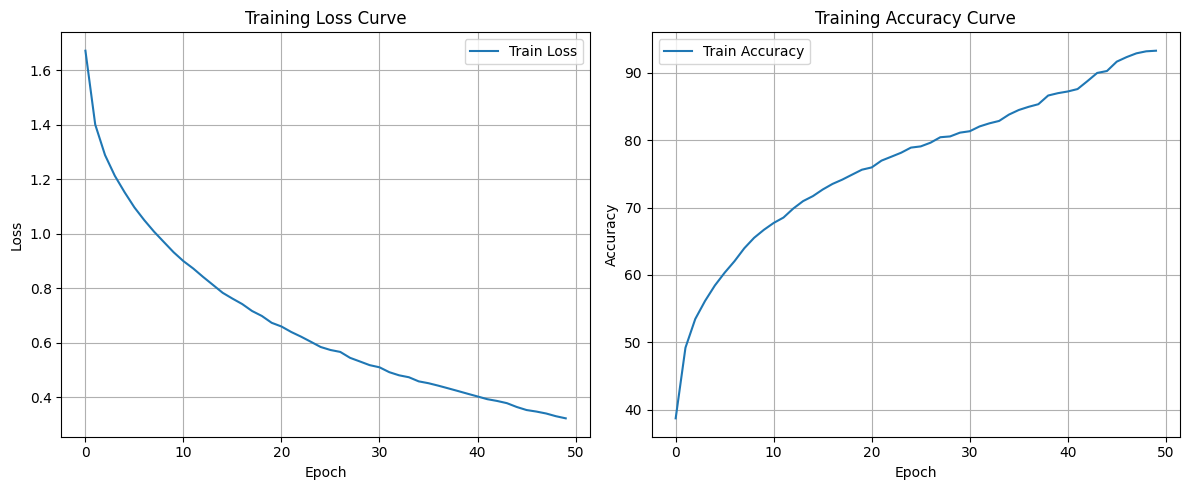

Final Test Loss: 1.3301 | Final Test Accuracy: 65.32%


In [13]:
plot_loss_and_acc(train_losses_ps2, train_accuracies_ps2)
test_loss_ps2, test_acc_ps2 = evaluate(model_ps2, test_loader_ps2)
print(f"\nFinal Test Loss: {round(test_loss_ps2, 4)} | Final Test Accuracy: {round(test_acc_ps2 * 100, 2)}%")

### Patch Size 4

> As trained above (Initial model)

## Differential Attention Transformer Encoder Block Performance on CIFAR10 with Patch Size Ablation

### Results:
Below is a comparison of the results with different patch sizes:

<table border="1" cellpadding="5">
  <thead>
    <tr>
      <th>Patch Size</th>
      <th>Train Loss</th>
      <th>Train Accuracy (%)</th>
      <th>Test Loss</th>
      <th>Test Accuracy (%)</th>
      <th>Training Time (seconds)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Patch size 2</td>
      <td>0.3234</td>
      <td>93.27</td>
      <td>1.3301</td>
      <td>65.32</td>
      <td>3267.04</td>
    </tr>
    <tr>
      <td>Patch size 4</td>
      <td>0.3194</td>
      <td>88.27</td>
      <td>1.3706</td>
      <td>65.72</td>
      <td>2140.0664</td>
    </tr>
  </tbody>
</table>

### Conclusion:
- **Patch size 2** resulted in a higher **train accuracy of 93.27%**, but the **test accuracy of 65.32%** was lower than expected, indicating that the model overfitted to the training data and struggled to generalize to the test set.
- **Patch size 4** provided a slightly lower **train accuracy of 88.27%**, but the **test accuracy of 65.72%** was marginally better, suggesting that a slightly larger patch size helped the model generalize better, despite a slight increase in test loss.
- **Training time** for **patch size 2** was significantly higher (3267.04 seconds) compared to **patch size 4** (2140.0664 seconds), making patch size 4 more efficient in terms of time.

In conclusion, while **patch size 2** showed higher training accuracy, **patch size 4** struck a better balance between generalization (test accuracy) and training efficiency. The slightly higher training time for patch size 2 did not justify the marginal improvement in train accuracy, so **patch size 4** is preferred for better overall performance.


## Hyperparameter tuning

In [ ]:
# Parameters constant throughtout the hyper param tuning section
patch_size = 4

train_dataset_param_tuning = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform)
test_dataset_param_tuning= CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform)

train_loader_param_tuning = DataLoader(train_dataset_param_tuning, batch_size=batch_size, shuffle=True)
test_loader_param_tuning = DataLoader(test_dataset_param_tuning, batch_size=batch_size, shuffle=False)

### Hyperparam 1

In [15]:
# Tuneable hyperparameters
emb_dim    = 92
depth      = 4
num_heads  = 2
mlp_ratio  = 2.0
dropout    = 0.1

model_emb_dim = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_emb_dim, train_accuracies_emb_dim = train_model(model_emb_dim, lr, epochs, train_loader_param_tuning, device)

Epoch 1/50
Train Loss: 1.6724 | Train Acc: 38.71%

Epoch 2/50
Train Loss: 1.4015 | Train Acc: 49.20%

Epoch 3/50
Train Loss: 1.2895 | Train Acc: 53.46%

Epoch 4/50
Train Loss: 1.2134 | Train Acc: 56.14%

Epoch 5/50
Train Loss: 1.1529 | Train Acc: 58.43%

Epoch 6/50
Train Loss: 1.0973 | Train Acc: 60.33%

Epoch 7/50
Train Loss: 1.0508 | Train Acc: 62.03%

Epoch 8/50
Train Loss: 1.0085 | Train Acc: 63.95%

Epoch 9/50
Train Loss: 0.9705 | Train Acc: 65.50%

Epoch 10/50
Train Loss: 0.9328 | Train Acc: 66.69%

Epoch 11/50
Train Loss: 0.9003 | Train Acc: 67.71%

Epoch 12/50
Train Loss: 0.8732 | Train Acc: 68.51%

Epoch 13/50
Train Loss: 0.8425 | Train Acc: 69.85%

Epoch 14/50
Train Loss: 0.8134 | Train Acc: 70.95%

Epoch 15/50
Train Loss: 0.7841 | Train Acc: 71.69%

Epoch 16/50
Train Loss: 0.7628 | Train Acc: 72.67%

Epoch 17/50
Train Loss: 0.7427 | Train Acc: 73.50%

Epoch 18/50
Train Loss: 0.7173 | Train Acc: 74.14%

Epoch 19/50
Train Loss: 0.6991 | Train Acc: 74.88%

Epoch 20/50
Train Los

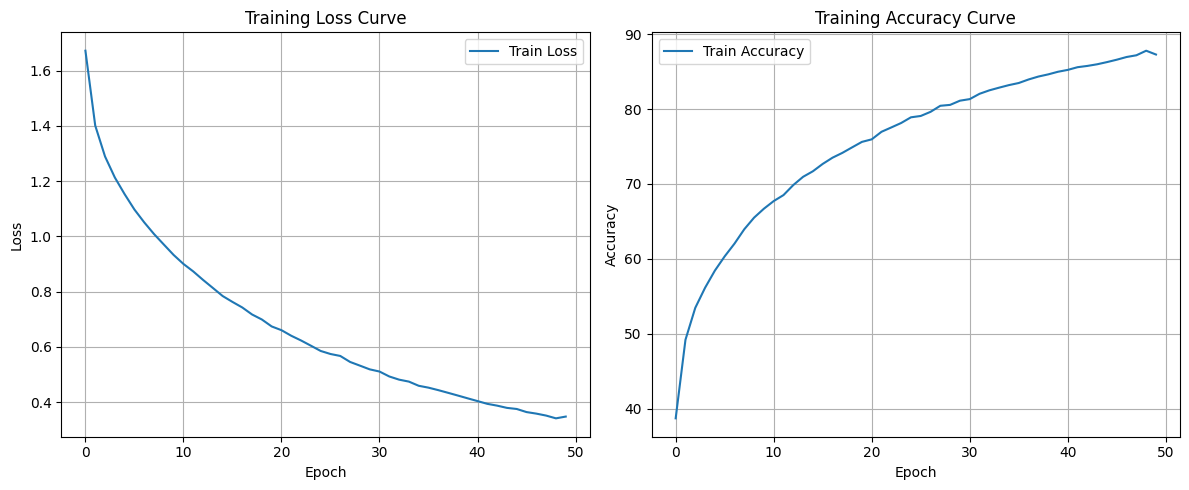


Final Test Loss: 1.3301 | Final Test Accuracy: 65.32%


In [14]:
plot_loss_and_acc(train_losses_emb_dim, train_accuracies_emb_dim)
test_loss_emb_dim, test_acc_emb_dim = evaluate(model_emb_dim, test_loader_param_tuning)
print(f"\nFinal Test Loss: {round(test_loss_emb_dim, 4)} | Final Test Accuracy: {round(test_acc_emb_dim * 100, 2)}%")

### Hyperparam 2

In [16]:
# Tuneable hyperparameters
emb_dim    = 128
depth      = 6
num_heads  = 4
mlp_ratio  = 2.0
dropout = 0.2

model_depth = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_depth, train_accuracies_depth = train_model(model_depth, lr, epochs, train_loader_param_tuning, device)

Epoch 1/50
Train Loss: 1.6607 | Train Acc: 39.22%

Epoch 2/50
Train Loss: 1.4014 | Train Acc: 49.42%

Epoch 3/50
Train Loss: 1.3054 | Train Acc: 52.91%

Epoch 4/50
Train Loss: 1.2425 | Train Acc: 55.15%

Epoch 5/50
Train Loss: 1.1884 | Train Acc: 57.24%

Epoch 6/50
Train Loss: 1.1466 | Train Acc: 58.64%

Epoch 7/50
Train Loss: 1.1088 | Train Acc: 60.27%

Epoch 8/50
Train Loss: 1.0747 | Train Acc: 61.41%

Epoch 9/50
Train Loss: 1.0407 | Train Acc: 62.52%

Epoch 10/50
Train Loss: 1.0100 | Train Acc: 63.73%

Epoch 11/50
Train Loss: 0.9755 | Train Acc: 65.20%

Epoch 12/50
Train Loss: 0.9445 | Train Acc: 66.27%

Epoch 13/50
Train Loss: 0.9196 | Train Acc: 67.09%

Epoch 14/50
Train Loss: 0.8929 | Train Acc: 67.90%

Epoch 15/50
Train Loss: 0.8665 | Train Acc: 69.02%

Epoch 16/50
Train Loss: 0.8433 | Train Acc: 69.73%

Epoch 17/50
Train Loss: 0.8139 | Train Acc: 70.79%

Epoch 18/50
Train Loss: 0.7866 | Train Acc: 71.76%

Epoch 19/50
Train Loss: 0.7653 | Train Acc: 72.62%

Epoch 20/50
Train Los

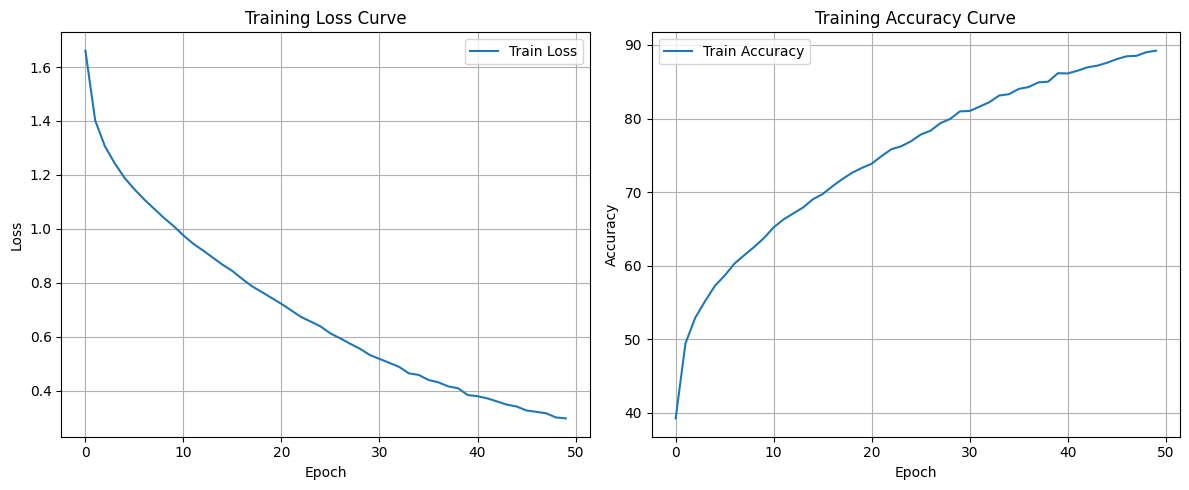


Final Test Loss: 1.4638 | Final Test Accuracy: 64.39%


In [17]:
plot_loss_and_acc(train_losses_depth, train_accuracies_depth)
test_loss_depth, test_acc_depth = evaluate(model_depth, test_loader_param_tuning)
print(f"\nFinal Test Loss: {round(test_loss_depth, 4)} | Final Test Accuracy: {round(test_acc_depth * 100, 2)}%")

### Hyperparam 3

In [18]:
# Tuneable hyperparameters
emb_dim    = 32
depth      = 6
num_heads  = 4
mlp_ratio  = 2.0
dropout    = 0.1

model_mlp_dim = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_mlp_dim, train_accuracies_mlp_dim = train_model(model_mlp_dim, lr, epochs, train_loader_param_tuning, device)

Epoch 1/50
Train Loss: 1.7371 | Train Acc: 36.25%

Epoch 2/50
Train Loss: 1.4206 | Train Acc: 48.82%

Epoch 3/50
Train Loss: 1.3121 | Train Acc: 52.69%

Epoch 4/50
Train Loss: 1.2424 | Train Acc: 55.07%

Epoch 5/50
Train Loss: 1.1853 | Train Acc: 57.34%

Epoch 6/50
Train Loss: 1.1438 | Train Acc: 58.92%

Epoch 7/50
Train Loss: 1.0996 | Train Acc: 60.40%

Epoch 8/50
Train Loss: 1.0650 | Train Acc: 61.72%

Epoch 9/50
Train Loss: 1.0373 | Train Acc: 62.84%

Epoch 10/50
Train Loss: 1.0093 | Train Acc: 63.84%

Epoch 11/50
Train Loss: 0.9807 | Train Acc: 64.87%

Epoch 12/50
Train Loss: 0.9551 | Train Acc: 65.73%

Epoch 13/50
Train Loss: 0.9327 | Train Acc: 66.70%

Epoch 14/50
Train Loss: 0.9099 | Train Acc: 67.39%

Epoch 15/50
Train Loss: 0.8924 | Train Acc: 68.19%

Epoch 16/50
Train Loss: 0.8772 | Train Acc: 68.57%

Epoch 17/50
Train Loss: 0.8562 | Train Acc: 69.63%

Epoch 18/50
Train Loss: 0.8415 | Train Acc: 69.88%

Epoch 19/50
Train Loss: 0.8272 | Train Acc: 70.47%

Epoch 20/50
Train Los

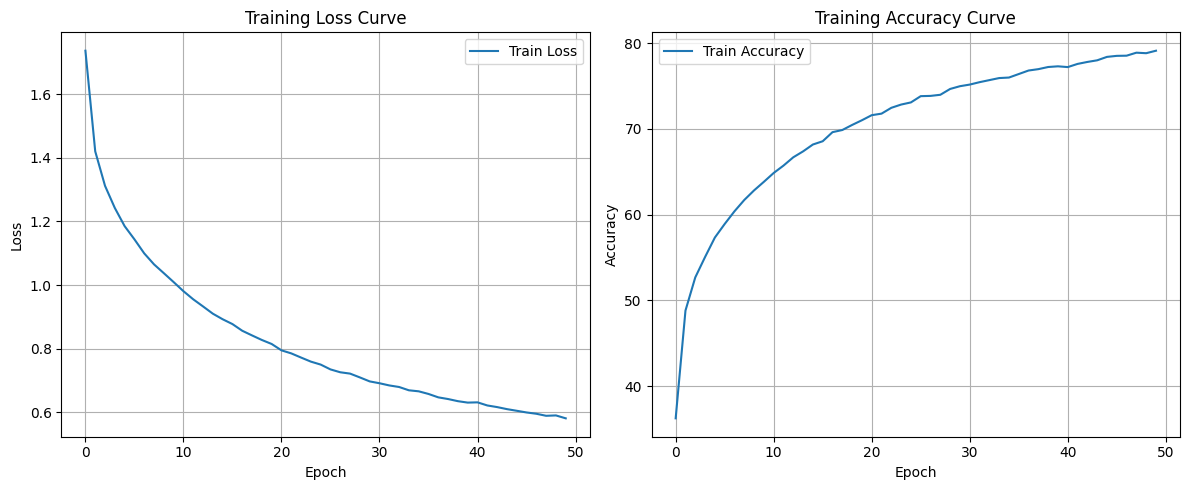


Final Test Loss: 1.0167 | Final Test Accuracy: 67.19%


In [19]:
plot_loss_and_acc(train_losses_mlp_dim, train_accuracies_mlp_dim)
test_loss_mlp_dim, test_acc_mlp_dim = evaluate(model_mlp_dim, test_loader_param_tuning)
print(f"\nFinal Test Loss: {round(test_loss_mlp_dim, 4)} | Final Test Accuracy: {round(test_acc_mlp_dim * 100, 2)}%")

## Data Augmentation

In [ ]:
# Parameters constant throughtout the data augmentation section
patch_size = 4
emb_dim    = 128
depth      = 6
num_heads  = 4
mlp_ratio  = 2.0
epochs     = 50
dropout    = 0.2

### Flip & Rotate

In [ ]:
transform_flip_n_rotate = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5), # 50% chance to flip
    transforms.RandomRotation(10), # Rotate by 10 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_flip_n_rotate = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_flip_n_rotate)
test_dataset_flip_n_rotate = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_flip_n_rotate)

train_loader_flip_n_rotate = DataLoader(train_dataset_flip_n_rotate, batch_size=batch_size, shuffle=True)
test_loader_flip_n_rotate = DataLoader(test_dataset_flip_n_rotate, batch_size=batch_size, shuffle=False)

In [22]:
model_flip_n_rotate = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_flip_n_rotate, train_accuracies_flip_n_rotate = train_model(model_flip_n_rotate, lr, epochs, train_loader_flip_n_rotate, device)

Epoch 1/50
Train Loss: 1.6621 | Train Acc: 39.36%

Epoch 2/50
Train Loss: 1.3703 | Train Acc: 50.57%

Epoch 3/50
Train Loss: 1.2582 | Train Acc: 54.74%

Epoch 4/50
Train Loss: 1.1785 | Train Acc: 57.76%

Epoch 5/50
Train Loss: 1.1257 | Train Acc: 59.74%

Epoch 6/50
Train Loss: 1.0735 | Train Acc: 61.71%

Epoch 7/50
Train Loss: 1.0333 | Train Acc: 63.02%

Epoch 8/50
Train Loss: 0.9970 | Train Acc: 64.57%

Epoch 9/50
Train Loss: 0.9630 | Train Acc: 65.54%

Epoch 10/50
Train Loss: 0.9373 | Train Acc: 66.42%

Epoch 11/50
Train Loss: 0.9106 | Train Acc: 67.46%

Epoch 12/50
Train Loss: 0.8804 | Train Acc: 68.61%

Epoch 13/50
Train Loss: 0.8634 | Train Acc: 69.26%

Epoch 14/50
Train Loss: 0.8392 | Train Acc: 70.16%

Epoch 15/50
Train Loss: 0.8234 | Train Acc: 70.52%

Epoch 16/50
Train Loss: 0.8041 | Train Acc: 71.13%

Epoch 17/50
Train Loss: 0.7869 | Train Acc: 71.84%

Epoch 18/50
Train Loss: 0.7698 | Train Acc: 72.49%

Epoch 19/50
Train Loss: 0.7551 | Train Acc: 73.26%

Epoch 20/50
Train Los

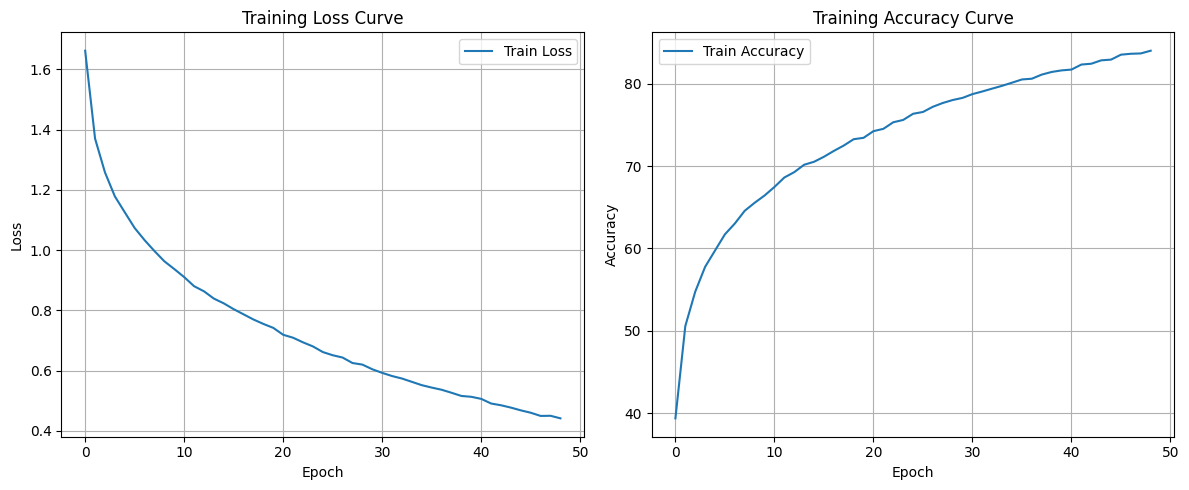


Final Test Loss: 0.9220 | Final Test Accuracy: 71.68%


In [23]:
plot_loss_and_acc(train_losses_flip_n_rotate, train_accuracies_flip_n_rotate)
test_loss_flip_n_rotate, test_acc_flip_n_rotate = evaluate(model_flip_n_rotate, test_loader_flip_n_rotate)
print(f"\nFinal Test Loss: {round(test_loss_flip_n_rotate, 4)} | Final Test Accuracy: {round(test_acc_flip_n_rotate * 100, 2)}%")

### Pad and Crop

In [ ]:
transform_pad_n_crop = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_pad_n_crop = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_pad_n_crop)
test_dataset_pad_n_crop = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_pad_n_crop)

train_loader_pad_n_crop = DataLoader(train_dataset_pad_n_crop, batch_size=batch_size, shuffle=True)
test_loader_pad_n_crop = DataLoader(test_dataset_pad_n_crop, batch_size=batch_size, shuffle=False)

In [20]:
model_pad_n_crop = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_pad_n_crop, train_accuracies_pad_n_crop = train_model(model_pad_n_crop, lr, epochs, train_loader_pad_n_crop, device)

Epoch 1/50
Train Loss: 1.8232 | Train Acc: 32.58%

Epoch 2/50
Train Loss: 1.5429 | Train Acc: 43.55%

Epoch 3/50
Train Loss: 1.4241 | Train Acc: 48.07%

Epoch 4/50
Train Loss: 1.3502 | Train Acc: 50.96%

Epoch 5/50
Train Loss: 1.2951 | Train Acc: 53.42%

Epoch 6/50
Train Loss: 1.2526 | Train Acc: 54.63%

Epoch 7/50
Train Loss: 1.2141 | Train Acc: 56.22%

Epoch 8/50
Train Loss: 1.1806 | Train Acc: 57.52%

Epoch 9/50
Train Loss: 1.1382 | Train Acc: 59.14%

Epoch 10/50
Train Loss: 1.1122 | Train Acc: 60.11%

Epoch 11/50
Train Loss: 1.0774 | Train Acc: 61.63%

Epoch 12/50
Train Loss: 1.0462 | Train Acc: 62.46%

Epoch 13/50
Train Loss: 1.0216 | Train Acc: 63.52%

Epoch 14/50
Train Loss: 0.9912 | Train Acc: 64.44%

Epoch 15/50
Train Loss: 0.9725 | Train Acc: 65.29%

Epoch 16/50
Train Loss: 0.9526 | Train Acc: 66.08%

Epoch 17/50
Train Loss: 0.9296 | Train Acc: 66.96%

Epoch 18/50
Train Loss: 0.9085 | Train Acc: 67.57%

Epoch 19/50
Train Loss: 0.8902 | Train Acc: 68.19%

Epoch 20/50
Train Los

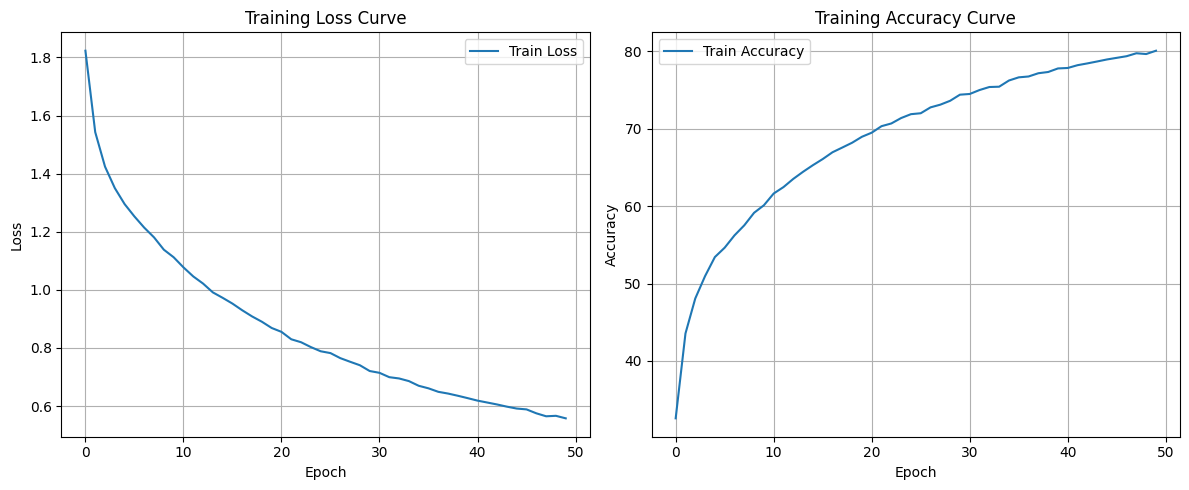


Final Test Loss: 0.6135 | Final Test Accuracy: 78.64%


In [21]:
plot_loss_and_acc(train_losses_pad_n_crop, train_accuracies_pad_n_crop)
test_loss_pad_n_crop, test_acc_pad_n_crop = evaluate(model_pad_n_crop, test_loader_pad_n_crop)
print(f"\nFinal Test Loss: {round(test_loss_pad_n_crop, 4)} | Final Test Accuracy: {round(test_acc_pad_n_crop * 100, 2)}%")

### Auto Augment

In [ ]:
transform_auto = transforms.Compose([
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10), # Learns best augmentations from data (more complex)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_auto = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_auto)
test_dataset_auto = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_auto)

train_loader_auto = DataLoader(train_dataset_auto, batch_size=batch_size, shuffle=True)
test_loader_auto = DataLoader(test_dataset_auto, batch_size=batch_size, shuffle=False)

In [24]:
model_auto = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout)
train_losses_auto, train_accuracies_auto = train_model(model_auto, lr, 50, train_loader_auto, device)

Epoch 1/50
Train Loss: 1.7712 | Train Acc: 34.56%

Epoch 2/50
Train Loss: 1.5294 | Train Acc: 44.06%

Epoch 3/50
Train Loss: 1.4437 | Train Acc: 47.45%

Epoch 4/50
Train Loss: 1.3930 | Train Acc: 49.51%

Epoch 5/50
Train Loss: 1.3458 | Train Acc: 51.41%

Epoch 6/50
Train Loss: 1.3110 | Train Acc: 52.58%

Epoch 7/50
Train Loss: 1.2785 | Train Acc: 53.89%

Epoch 8/50
Train Loss: 1.2406 | Train Acc: 55.07%

Epoch 9/50
Train Loss: 1.2114 | Train Acc: 56.38%

Epoch 10/50
Train Loss: 1.1816 | Train Acc: 57.35%

Epoch 11/50
Train Loss: 1.1549 | Train Acc: 58.40%

Epoch 12/50
Train Loss: 1.1255 | Train Acc: 59.36%

Epoch 13/50
Train Loss: 1.1091 | Train Acc: 60.39%

Epoch 14/50
Train Loss: 1.0848 | Train Acc: 61.11%

Epoch 15/50
Train Loss: 1.0573 | Train Acc: 62.11%

Epoch 16/50
Train Loss: 1.0398 | Train Acc: 62.72%

Epoch 17/50
Train Loss: 1.0144 | Train Acc: 63.37%

Epoch 18/50
Train Loss: 0.9958 | Train Acc: 64.20%

Epoch 19/50
Train Loss: 0.9809 | Train Acc: 64.89%

Epoch 20/50
Train Los

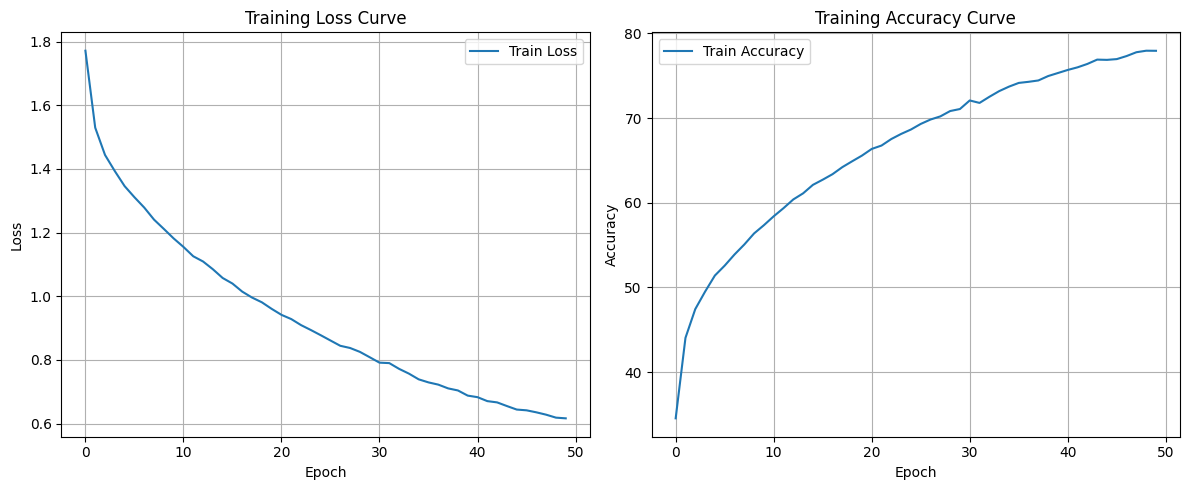


Final Test Loss: 0.6406 | Final Test Accuracy: 77.6%


In [25]:
plot_loss_and_acc(train_losses_auto, train_accuracies_auto)
test_loss_auto, test_acc_auto = evaluate(model_auto, test_loader_auto)
print(f"\nFinal Test Loss: {round(test_loss_auto, 4)} | Final Test Accuracy: {round(test_acc_auto * 100, 2)}%")

## Differential Attention Transformer Encoder Block Performance on CIFAR10 with Data Augmentation

### Results:
Below is a comparison of the results with different data augmentation techniques:

<table border="1" cellpadding="5">
  <thead>
    <tr>
      <th>Data Augmentation</th>
      <th>Train Loss</th>
      <th>Train Accuracy (%)</th>
      <th>Test Loss</th>
      <th>Test Accuracy (%)</th>
      <th>Training Time (seconds)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Flip and Rotate</td>
      <td>0.6164</td>
      <td>77.93</td>
      <td>0.9220</td>
      <td>71.68</td>
      <td>2220.01</td>
    </tr>
    <tr>
      <td>Pad and Crop</td>
      <td>0.5576</td>
      <td>80.08</td>
      <td>0.6406</td>
      <td>77.60</td>
      <td>2249.089</td>
    </tr>
    <tr>
      <td>Auto Augment</td>
      <td>0.4417</td>
      <td>84.01</td>
      <td>0.6135</td>
      <td>78.64</td>
      <td>2314.076</td>
    </tr>
  </tbody>
</table>

### Conclusion:
- **Auto Augment** achieved the highest **test accuracy of 78.64%** and showed the best generalization, despite requiring the most training time (2314.076 seconds).
- **Pad and Crop** had a solid **test accuracy of 77.60%**, offering a good balance between accuracy and training time (2249.089 seconds).
- **Flip and Rotate** performed the weakest with **test accuracy of 71.68%**, though it required the least training time (2220.01 seconds).

In summary, **Auto Augment** outperformed the other methods in accuracy and generalization, while **Pad and Crop** was a close second.


## Positional Embeddings Experimentation

In [ ]:
# Parameters constant throughtout the positional embeddings experimentation section
patch_size = 4
emb_dim    = 128
depth      = 4
num_heads  = 4
mlp_ratio  = 2.0

transform_pos_emb = transforms.Compose([
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10), # Learns best augmentations from data (more complex)
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

train_dataset_pos_emb = CIFAR10PDataset(train=True, patch_size=patch_size, transform=transform_pos_emb)
test_dataset_pos_emb = CIFAR10PDataset(train=False, patch_size=patch_size, transform=transform_pos_emb)

train_loader_pos_emb = DataLoader(train_dataset_pos_emb, batch_size=batch_size, shuffle=True)
test_loader_pos_emb = DataLoader(test_dataset_pos_emb, batch_size=batch_size, shuffle=False)

### No positional embeddings

In [26]:
model_no_pos_emb = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = None)
train_losses_no_pos_emb, train_accuracies_no_pos_emb = train_model(model_no_pos_emb, lr, epochs, train_loader_pos_emb, device)

Epoch 1/50
Train Loss: 1.7854 | Train Acc: 32.93%

Epoch 2/50
Train Loss: 1.5545 | Train Acc: 42.65%

Epoch 3/50
Train Loss: 1.4481 | Train Acc: 47.18%

Epoch 4/50
Train Loss: 1.3953 | Train Acc: 49.02%

Epoch 5/50
Train Loss: 1.3519 | Train Acc: 50.80%

Epoch 6/50
Train Loss: 1.3199 | Train Acc: 52.12%

Epoch 7/50
Train Loss: 1.2875 | Train Acc: 53.46%

Epoch 8/50
Train Loss: 1.2685 | Train Acc: 54.03%

Epoch 9/50
Train Loss: 1.2432 | Train Acc: 55.13%

Epoch 10/50
Train Loss: 1.2190 | Train Acc: 55.87%

Epoch 11/50
Train Loss: 1.2058 | Train Acc: 56.47%

Epoch 12/50
Train Loss: 1.1881 | Train Acc: 57.05%

Epoch 13/50
Train Loss: 1.1733 | Train Acc: 57.64%

Epoch 14/50
Train Loss: 1.1550 | Train Acc: 58.40%

Epoch 15/50
Train Loss: 1.1408 | Train Acc: 58.76%

Epoch 16/50
Train Loss: 1.1341 | Train Acc: 59.02%

Epoch 17/50
Train Loss: 1.1156 | Train Acc: 59.83%

Epoch 18/50
Train Loss: 1.1058 | Train Acc: 60.13%

Epoch 19/50
Train Loss: 1.0953 | Train Acc: 60.58%

Epoch 20/50
Train Los

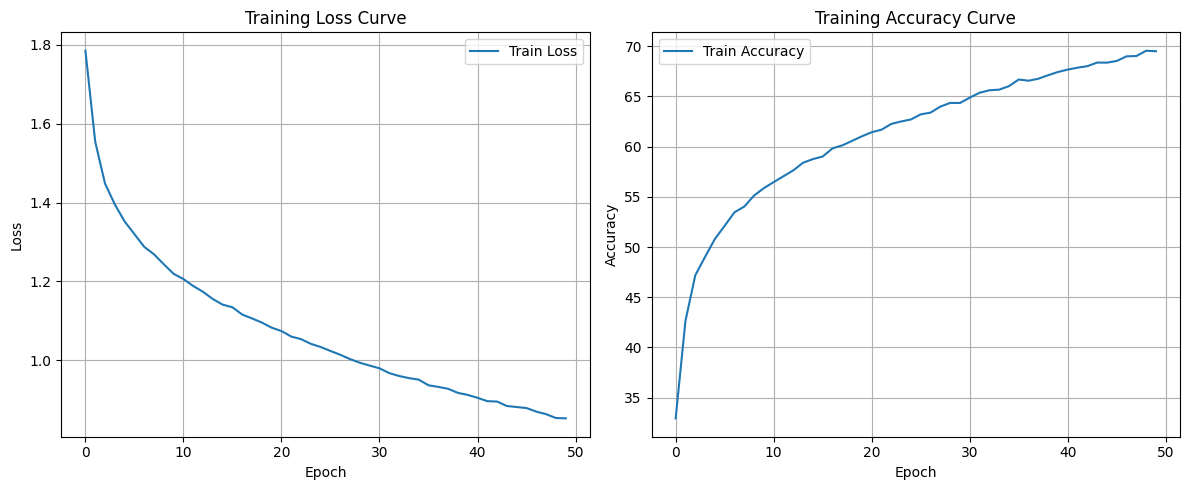


Final Test Loss: 0.9069 | Final Test Accuracy: 68.37%


In [27]:
plot_loss_and_acc(train_losses_no_pos_emb, train_accuracies_no_pos_emb)
test_loss_no_pos_emb, test_acc_no_pos_emb = evaluate(model_no_pos_emb, test_loader_pos_emb)
print(f"\nFinal Test Loss: {round(test_loss_no_pos_emb, 4)} | Final Test Accuracy: {round(test_acc_no_pos_emb * 100, 2)}%")

### 1D learned embeddings

> Ran above (Initial Model)

### 2D learned embeddings

In [28]:
model_2d_emb = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = "2d")
train_losses_2d_emb, train_accuracies_2d_emb = train_model(model_2d_emb, lr, epochs, train_loader_pos_emb, device)

Epoch 1/50
Train Loss: 1.7362 | Train Acc: 35.96%

Epoch 2/50
Train Loss: 1.4915 | Train Acc: 45.53%

Epoch 3/50
Train Loss: 1.4043 | Train Acc: 48.64%

Epoch 4/50
Train Loss: 1.3480 | Train Acc: 50.84%

Epoch 5/50
Train Loss: 1.3076 | Train Acc: 52.68%

Epoch 6/50
Train Loss: 1.2653 | Train Acc: 53.93%

Epoch 7/50
Train Loss: 1.2312 | Train Acc: 55.76%

Epoch 8/50
Train Loss: 1.1956 | Train Acc: 56.93%

Epoch 9/50
Train Loss: 1.1747 | Train Acc: 57.54%

Epoch 10/50
Train Loss: 1.1498 | Train Acc: 58.61%

Epoch 11/50
Train Loss: 1.1139 | Train Acc: 59.85%

Epoch 12/50
Train Loss: 1.0937 | Train Acc: 60.71%

Epoch 13/50
Train Loss: 1.0716 | Train Acc: 61.51%

Epoch 14/50
Train Loss: 1.0489 | Train Acc: 62.27%

Epoch 15/50
Train Loss: 1.0339 | Train Acc: 62.84%

Epoch 16/50
Train Loss: 1.0093 | Train Acc: 63.95%

Epoch 17/50
Train Loss: 0.9898 | Train Acc: 64.52%

Epoch 18/50
Train Loss: 0.9711 | Train Acc: 65.02%

Epoch 19/50
Train Loss: 0.9514 | Train Acc: 65.98%

Epoch 20/50
Train Los

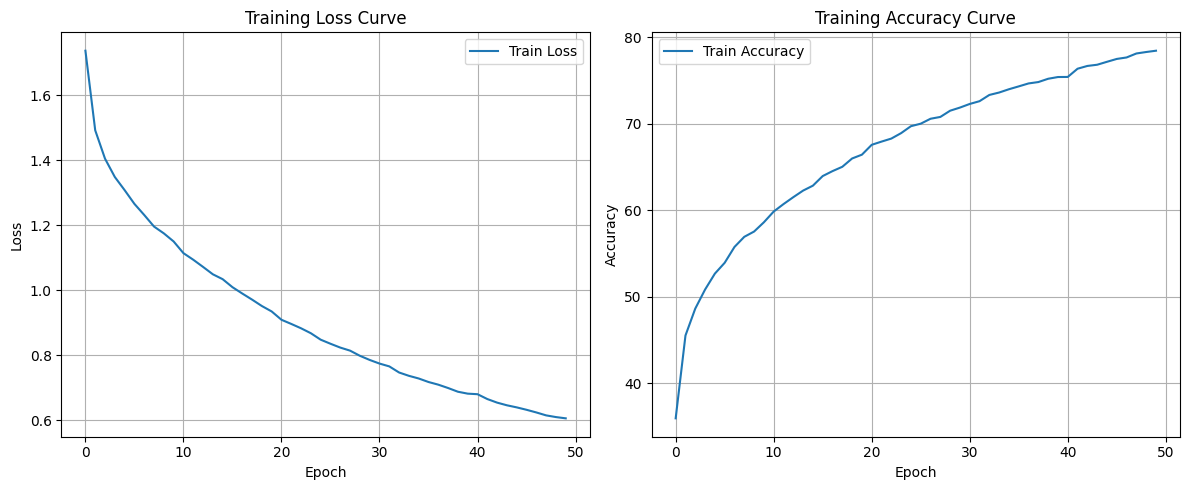


Final Test Loss: 0.66894 | Final Test Accuracy: 76.96%


In [29]:
plot_loss_and_acc(train_losses_2d_emb, train_accuracies_2d_emb)
test_loss_2d_emb, test_acc_2d_emb = evaluate(model_2d_emb, test_loader_pos_emb)
print(f"\nFinal Test Loss: {round(test_loss_2d_emb, 4)} | Final Test Accuracy: {round(test_acc_2d_emb * 100, 2)}%")

### Sinusoidal embeddings

In [30]:
model_sin_emb = ViT(img_size, patch_size, in_channels, num_classes, emb_dim, depth, num_heads, mlp_ratio, dropout, positional_embeddings = "sinusoidal")
train_losses_sin_emb, train_accuracies_sin_emb = train_model(model_sin_emb, lr, epochs, train_loader_pos_emb, device)

Epoch 1/50
Train Loss: 1.6981 | Train Acc: 37.48%

Epoch 2/50
Train Loss: 1.4300 | Train Acc: 47.99%

Epoch 3/50
Train Loss: 1.3337 | Train Acc: 51.41%

Epoch 4/50
Train Loss: 1.2672 | Train Acc: 54.26%

Epoch 5/50
Train Loss: 1.2189 | Train Acc: 56.04%

Epoch 6/50
Train Loss: 1.1720 | Train Acc: 57.81%

Epoch 7/50
Train Loss: 1.1490 | Train Acc: 58.65%

Epoch 8/50
Train Loss: 1.1092 | Train Acc: 59.83%

Epoch 9/50
Train Loss: 1.0812 | Train Acc: 61.10%

Epoch 10/50
Train Loss: 1.0480 | Train Acc: 62.59%

Epoch 11/50
Train Loss: 1.0310 | Train Acc: 62.96%

Epoch 12/50
Train Loss: 1.0135 | Train Acc: 63.83%

Epoch 13/50
Train Loss: 0.9897 | Train Acc: 64.50%

Epoch 14/50
Train Loss: 0.9654 | Train Acc: 65.52%

Epoch 15/50
Train Loss: 0.9513 | Train Acc: 65.87%

Epoch 16/50
Train Loss: 0.9336 | Train Acc: 66.32%

Epoch 17/50
Train Loss: 0.9132 | Train Acc: 67.49%

Epoch 18/50
Train Loss: 0.8963 | Train Acc: 68.17%

Epoch 19/50
Train Loss: 0.8849 | Train Acc: 68.38%

Epoch 20/50
Train Los

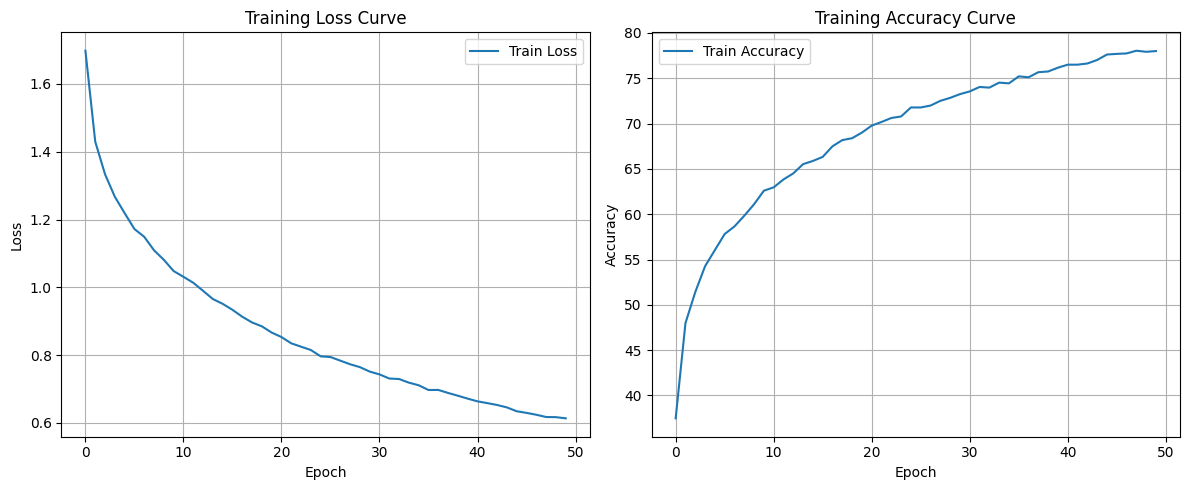


Final Test Loss: 0.6588 | Final Test Accuracy: 78.02%


In [31]:
plot_loss_and_acc(train_losses_sin_emb, train_accuracies_sin_emb)
test_loss_sin_emb, test_acc_sin_emb = evaluate(model_sin_emb, test_loader_pos_emb)
print(f"\nFinal Test Loss: {round(test_loss_sin_emb, 4)} | Final Test Accuracy: {round(test_acc_sin_emb * 100, 2)}%")

## Summary Positional Embeddings

> Similar to Q1

## DINO Attention Maps

### 1st Image - Airplane (From CIFAR10)

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall8_300ep_pretrain.pth
100%|███████████████████████████████████████| 82.7M/82.7M [00:00<00:00, 164MB/s]
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


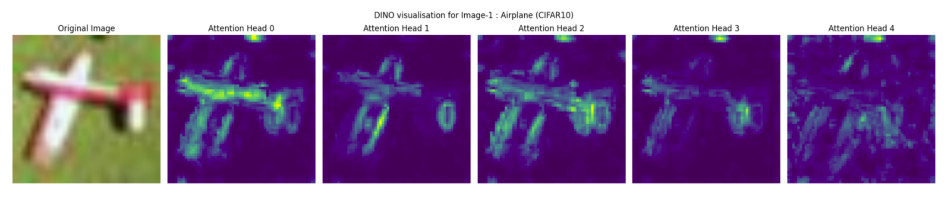

In [36]:
# Generating the heatmaps
!python /kaggle/input/dino-code/dino/visualize_attention.py --image_path /kaggle/input/sample-images-to-visualise/images/airplane.jpg

# Plotting the output
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for i in range(6):
    if i == 0:
        img = cv2.imread("/kaggle/working/img.png")
        axes[i].set_title("Original Image")
    else:
        img = cv2.imread(f"/kaggle/working/attn-head{i - 1}.png")
        axes[i].set_title(f"Attention Head {i - 1}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.suptitle(f"DINO visualisation for Image-1 : Airplane (CIFAR10)")
plt.tight_layout()
plt.show()

### 2nd Image - Ship (CIFAR10)

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
./attn-head0.png saved.
./attn-head1.png saved.
./attn-head2.png saved.
./attn-head3.png saved.
./attn-head4.png saved.
./attn-head5.png saved.


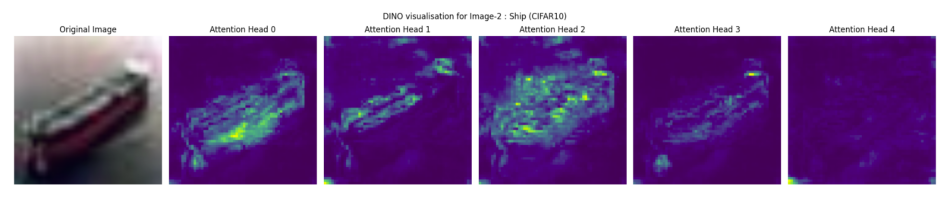

In [37]:
# Generating the heatmaps
!python /kaggle/input/dino-code/dino/visualize_attention.py --image_path /kaggle/input/sample-images-to-visualise/images/ship.jpg

# Plotting the output
fig, axes = plt.subplots(1, 6, figsize=(20, 4))

for i in range(6):
    if i == 0:
        img = cv2.imread("/kaggle/working/img.png")
        axes[i].set_title("Original Image")
    else:
        img = cv2.imread(f"/kaggle/working/attn-head{i - 1}.png")
        axes[i].set_title(f"Attention Head {i - 1}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.suptitle(f"DINO visualisation for Image-2 : Ship (CIFAR10)")
plt.tight_layout()
plt.show()

## ViT CIFAR-10 Attention Maps

For Image 1


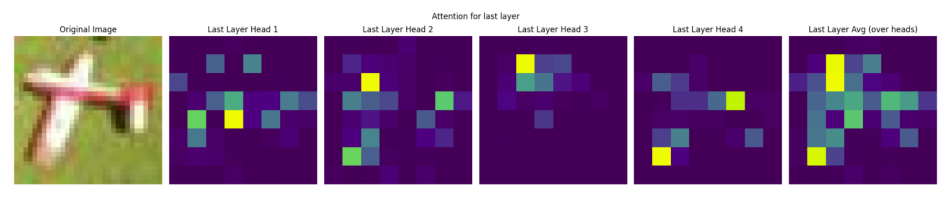

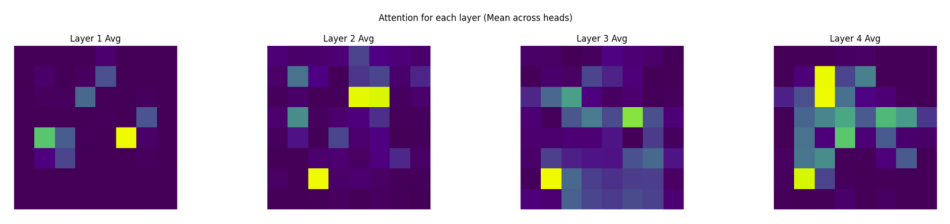

For Image 2


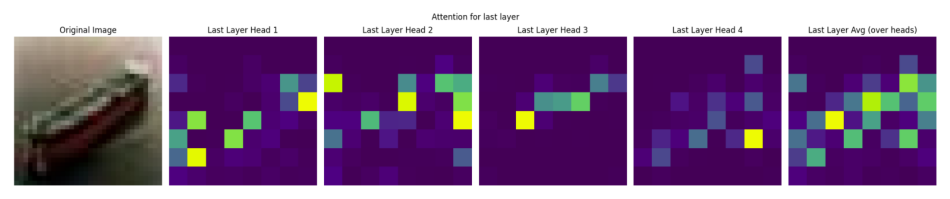

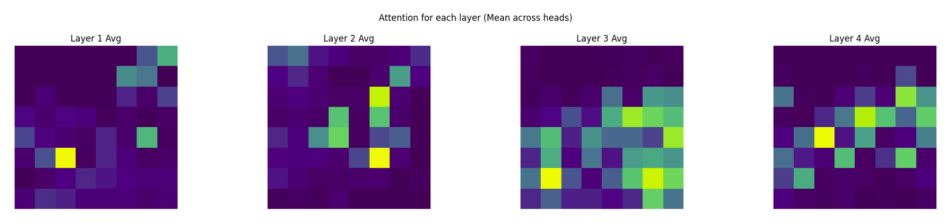

In [ ]:
from PIL import Image
img1 = Image.open("/kaggle/input/sample-images-to-visualise/images/airplane.jpg").convert("RGB")
img2 = Image.open("/kaggle/input/sample-images-to-visualise/images/ship.jpg").convert("RGB")

imgs = [img1, img2]

transform_vis = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

img1_tensor = transform_vis(img1)  # [3, 32, 32]
img2_tensor = transform_vis(img2)  # [3, 32, 32]

# Patching function
def img_to_patches(img, patch_size=4):
    C, _, _ = img.shape
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    patches = patches.permute(1, 2, 0, 3, 4).contiguous()  # [num_patches_H, num_patches_W, C, p, p]
    patches = patches.view(-1, C * patch_size * patch_size)  # [num_patches, patch_dim]
    return patches

# Apply patching
patch_size = 4
patches1 = img_to_patches(img1_tensor, patch_size=patch_size)  # [64, 48]
patches2 = img_to_patches(img2_tensor, patch_size=patch_size)  # [64, 48]

# Create a batch of patch sequences
images = torch.stack([patches1, patches2])  # [2, 64, 48]  # shape: [2, 3, 32, 32]

def get_maps(model, img, device):
    final_output = []

    org_img = img.clone()
    final_output.append((org_img, "Original Image"))

    img = img.to(device)
    _ = model(img.unsqueeze(0))  # Forward pass (returns ignored if needed)
    
    attn_weights = model.transformer.attn_weights  # List of tensors: [L][1, H, T, T]

    last_layer_attn = attn_weights[-1]
    num_heads = last_layer_attn.shape[1]
    num_layers = len(attn_weights)

    # Get [CLS] to all patch tokens (ignore [CLS] itself at index 0)
    grid_size = int((last_layer_attn.shape[-1] - 1) ** 0.5)

    # Head-wise attention from last layer
    for head_idx in range(num_heads):
        cls_attn = last_layer_attn[0, head_idx, 0, 1:]  # [patches]
        attn_map = cls_attn.reshape(grid_size, grid_size).detach().cpu().numpy()
        final_output.append((attn_map, f"Last Layer Head {head_idx + 1}"))

    # Aggregated attention across heads in last layer
    cls_attn_avg = last_layer_attn[0, :, 0, 1:].mean(dim=0)
    attn_map_avg = cls_attn_avg.reshape(grid_size, grid_size).detach().cpu().numpy()
    final_output.append((attn_map_avg, "Last Layer Avg (over heads)"))

    final_output2 = []

    # Attention from all layers (aggregated over heads)
    for layer_idx in range(num_layers):
        layer_attn = attn_weights[layer_idx]
        cls_attn = layer_attn[0, :, 0, 1:].mean(dim=0)  # mean over heads
        attn_map = cls_attn.reshape(grid_size, grid_size).detach().cpu().numpy()
        final_output2.append((attn_map, f"Layer {layer_idx + 1} Avg"))

    return final_output, final_output2

for img_idx, img in enumerate(images):
    print(f"For image {img_idx + 1}")
    last_layer_maps, layer_wise_maps = get_maps(model_initial, img, device)
    
    fig, axes = plt.subplots(1, len(last_layer_maps), figsize=(20, 4))
    for i in range(len(last_layer_maps)):
        if i == 0:
            axes[i].imshow(imgs[img_idx])
            axes[i].set_title("Original Image")
        else:
            axes[i].imshow(last_layer_maps[i][0])
            axes[i].set_title(last_layer_maps[i][1])
        axes[i].axis('off')
    plt.suptitle("Attention for last layer")
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, len(layer_wise_maps), figsize=(20, 4))
    for i in range(len(layer_wise_maps)):
        axes[i].imshow(layer_wise_maps[i][0])
        axes[i].set_title(layer_wise_maps[i][1])
        axes[i].axis('off')
    plt.suptitle("Attention for each layer (Mean across heads)")
    plt.tight_layout()
    plt.show()

## Attention Rollout

For Image 1


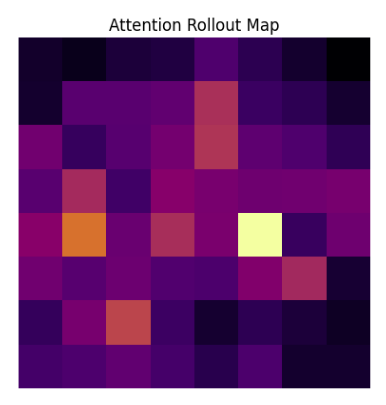

For Image 2


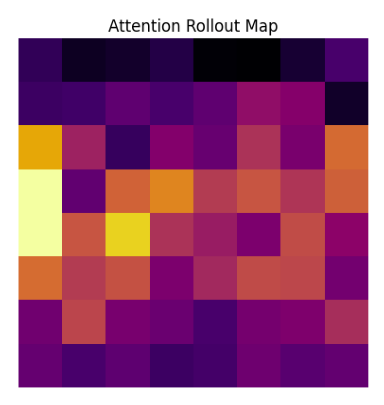

In [ ]:
def compute_attention_rollout(attn_weights, add_residual=True):
    num_layers = len(attn_weights)
    batch_size, num_heads, T, _ = attn_weights[0].shape
    device = attn_weights[0].device

    # Start with identity
    rollout = torch.eye(T, device=device).unsqueeze(0).repeat(batch_size, 1, 1)  # [1, T, T]

    for layer_attn in attn_weights:
        # shape: [1, H, T, T]
        attn_mean = layer_attn.mean(dim=1)  # Mean over heads → [1, T, T]
        
        if add_residual:
            attn_mean += torch.eye(T, device=device).unsqueeze(0)  # Add identity
            attn_mean /= attn_mean.sum(dim=-1, keepdim=True)       # Normalize rows

        rollout = attn_mean @ rollout  # Matrix multiply each step

    return rollout.squeeze(0)  # Final shape: [T, T]

for img_idx, img in enumerate(images):
    print(f"For Image {img_idx + 1}")
    org_img = img.clone()
    img = img.to(device)
    _ = model_initial(img.unsqueeze(0))  # Forward pass (returns ignored if needed)
    
    attn_weights = model_initial.transformer.attn_weights  # List of tensors: [L][1, H, T, T]
    last_layer_attn = attn_weights[-1]
    rollout_attn = compute_attention_rollout(attn_weights)  # [T, T]
    cls_to_patches = rollout_attn[0, 1:]  # CLS attends to patch tokens

    # Visualize (assuming square patch layout)
    num_patches = int((cls_to_patches.shape[0]) ** 0.5)
    heatmap = cls_to_patches.reshape(num_patches, num_patches).detach().cpu().numpy()
    
    # Optional: upscale to original image resolution
    grid_size = int((last_layer_attn.shape[-1] - 1) ** 0.5)
    heatmap = cv2.resize(heatmap, (grid_size, grid_size))  # (H, W)
    plt.imshow(heatmap, cmap='inferno')
    plt.axis('off')
    plt.title("Attention Rollout Map")
    plt.show()

## Positional Embeddings Visualisation

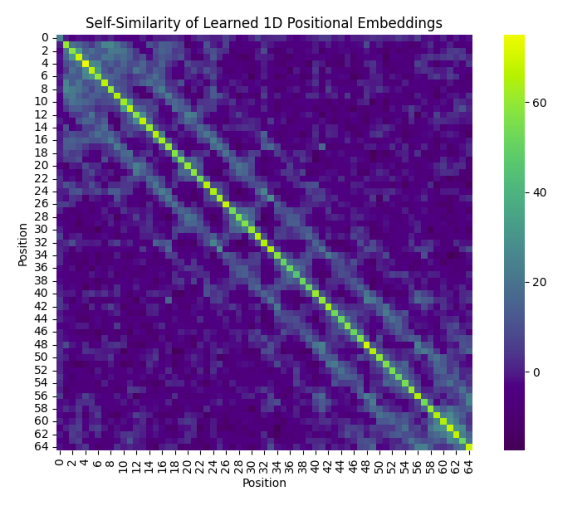

In [ ]:
pos_emb = model_initial.pos_embed.squeeze(0).detach().cpu()
similarity = pos_emb @ pos_emb.T

plt.figure(figsize=(8, 6))
sns.heatmap(similarity.numpy(), cmap='viridis', square=True)
plt.title("Self-Similarity of Learned 1D Positional Embeddings")
plt.xlabel("Position")
plt.ylabel("Position")
plt.tight_layout()
plt.show()

## Overall Summary

### Summary for Differential Attention Vision Transformer (Differential ViT) on CIFAR10:

The Differential Attention Transformer Encoder Block (Differential ViT) was tested with different patch sizes, data augmentations, and positional embeddings. The patch size ablation revealed that while smaller patches (size 2) provided better training accuracy, they resulted in slower training and lower test accuracy. Auto Augment emerged as the best data augmentation strategy, achieving a test accuracy of 78.64%, indicating superior generalization compared to other techniques like Pad and Crop and Flip and Rotate. In terms of positional embeddings, the performance was similar across 1D, 2D, and sinusoidal embeddings, with 1D embedding being the most efficient in terms of training time and accuracy. Overall, Auto Augment combined with 1D positional embedding offered the best results for the Differential ViT.

## Comparison between Normal Attention and Differential Attention Mechanism

- **Normal ViT** performed well with **1D positional embedding** and **Pad and Crop augmentation**, achieving a test accuracy of up to 78.79%. It showed a good balance between performance and training time, with smaller patch sizes yielding better results, though at the cost of longer training times.
  
- **Differential ViT** outperformed Normal ViT in terms of generalization with **Auto Augment**, reaching a **test accuracy of 78.64%**. However, the training time for Differential ViT was generally higher. The performance across positional embeddings was similar, with **1D embedding** being the most efficient.

In summary, while both models performed similarly, **Differential ViT** excelled in generalization with **Auto Augment**, while **Normal ViT** showed a more efficient balance of speed and performance using **1D embedding** and **Pad and Crop**.